In [10]:
import polars as pl
import pandas as pd
import numpy as np
from pymongo import MongoClient 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
#from tqdm import tqdm
import sqlite3
import json
import pprint
from datetime import datetime, timedelta


## MongoDB management

In [2]:
# Connect to the MongoDB server
client = MongoClient('mongodb://localhost:27017/')

db = client['event_database']
collection = db['events']



In [3]:
print("Databases: ",client.list_database_names())
print("Collections: ",db.list_collection_names())

Databases:  ['admin', 'config', 'event_database', 'local', 'test_database']
Collections:  ['event_counts', 'events']


# Query

In [4]:
# Define the events of interest
events_of_interest = ['Picking Up Dark Matter', 'Sleeping', 'Patting',
       'Claim Daily Rewards', 'Waking Up', 'Feeding', 'Visit Sanctuary',
       'Shop Transaction', 'Calling Pet', 'Swap Wearable',
       'Equip Wearable', 'Detach Wearable']

# Fetch the data from MongoDB with specific date and events of interest
query = {
    "event": {"$in": events_of_interest},
    }

print(query)

{'event': {'$in': ['Picking Up Dark Matter', 'Sleeping', 'Patting', 'Claim Daily Rewards', 'Waking Up', 'Feeding', 'Visit Sanctuary', 'Shop Transaction', 'Calling Pet', 'Swap Wearable', 'Equip Wearable', 'Detach Wearable']}}


In [5]:
# Fetch data from collection using query and make it a dictionary
data = list(collection.find(query))
print(f"Type: {type(data)}")

df = pl.DataFrame(data)
print(f"Type: {type(df)}")

Type: <class 'list'>
Type: <class 'polars.dataframe.frame.DataFrame'>


In [6]:
df = df.unnest('properties')
print(f"Size: {df.shape}")
df = df.select(['_id', 'event', 'distinct_id'])
print(f"Size: {df.shape}")

Size: (1448274, 13)
Size: (1448274, 3)


In [7]:
print(f"Unique users: {df['distinct_id'].n_unique()}")

df

Unique users: 4225


_id,event,distinct_id
object,str,str
6492393b1b852c78ed17cab9,"""Picking Up Dar…","""5fda86a5-0d49-…"
6492393b1b852c78ed17caba,"""Sleeping""","""5fda86a5-0d49-…"
6492393b1b852c78ed17cabb,"""Patting""","""5fda86a5-0d49-…"
6492393b1b852c78ed17cabc,"""Patting""","""5fda86a5-0d49-…"
6492393b1b852c78ed17cabd,"""Patting""","""5fda86a5-0d49-…"
6492393b1b852c78ed17cabe,"""Patting""","""5fda86a5-0d49-…"
6492393b1b852c78ed17cabf,"""Patting""","""5fda86a5-0d49-…"
6492393b1b852c78ed17cac0,"""Patting""","""5fda86a5-0d49-…"
6492393b1b852c78ed17cac1,"""Patting""","""5fda86a5-0d49-…"


In [8]:
# Count the number of events per user
event_counts = df.groupby(['distinct_id', 'event']).agg(pl.count('event').alias('count'))

event_counts = event_counts.pivot(index="distinct_id", columns="event", values="count", aggregate_function=None).fill_null(0)

event_counts


distinct_id,Sleeping,Picking Up Dark Matter,Feeding,Claim Daily Rewards,Visit Sanctuary,Patting,Shop Transaction,Waking Up,Calling Pet,Swap Wearable,Equip Wearable,Detach Wearable
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""447cc0d0-b277-…",58,814,233,1,0,1602,0,69,0,1,0,0
"""bdc39283-5b15-…",56,1220,223,1,0,1009,0,123,0,1,1,0
"""e61f9606-4663-…",1,7,7,2,1,61,6,1,0,0,0,0
"""33d18d33-6b5a-…",7,11,4,1,3,62,0,2,0,0,0,0
"""134e500c-cc67-…",79,258,394,1,0,2550,2,103,0,0,0,0
"""2e32d5ca-376f-…",3,3,0,0,1,6,0,1,0,0,0,0
"""7f0b51cb-3c9c-…",2,8,10,0,11,52,7,2,0,0,0,0
"""17a8c6ac-91ff-…",185,650,398,2,3,4508,13,259,0,113,35,18
"""a74a643c-cba2-…",1,6,1,0,1,3,1,1,0,0,0,0


In [26]:
# To use seaborn, convert polars dataframe to pandas dataframe
event_counts_pd = event_counts.to_pandas()

# Connect to the SQLite database
conn = sqlite3.connect('../databases/event_database.db')
c = conn.cursor()

# get this database file path
db_path = conn.execute("PRAGMA database_list;").fetchall()[0][2]
print(db_path)

# send event_counts_pd to the database
event_counts_pd.to_sql('event_counts', conn, if_exists='replace', index=True)


/Users/joaovictorfarrulladarze/Desktop/Metapals/Workspace/Dashboard/databases/event_database.db


4225

In [27]:
# Query the database
c.execute('''
SELECT * FROM event_counts
          ''')

# get the name of the columns in the table
column_names = list(map(lambda x: x[0], c.description))

# make a dataframe from the query result
staged_data = pd.DataFrame(c.fetchall(), columns=column_names)

# get a list of all the database names in the sqlite database
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())



[('event_counts',)]


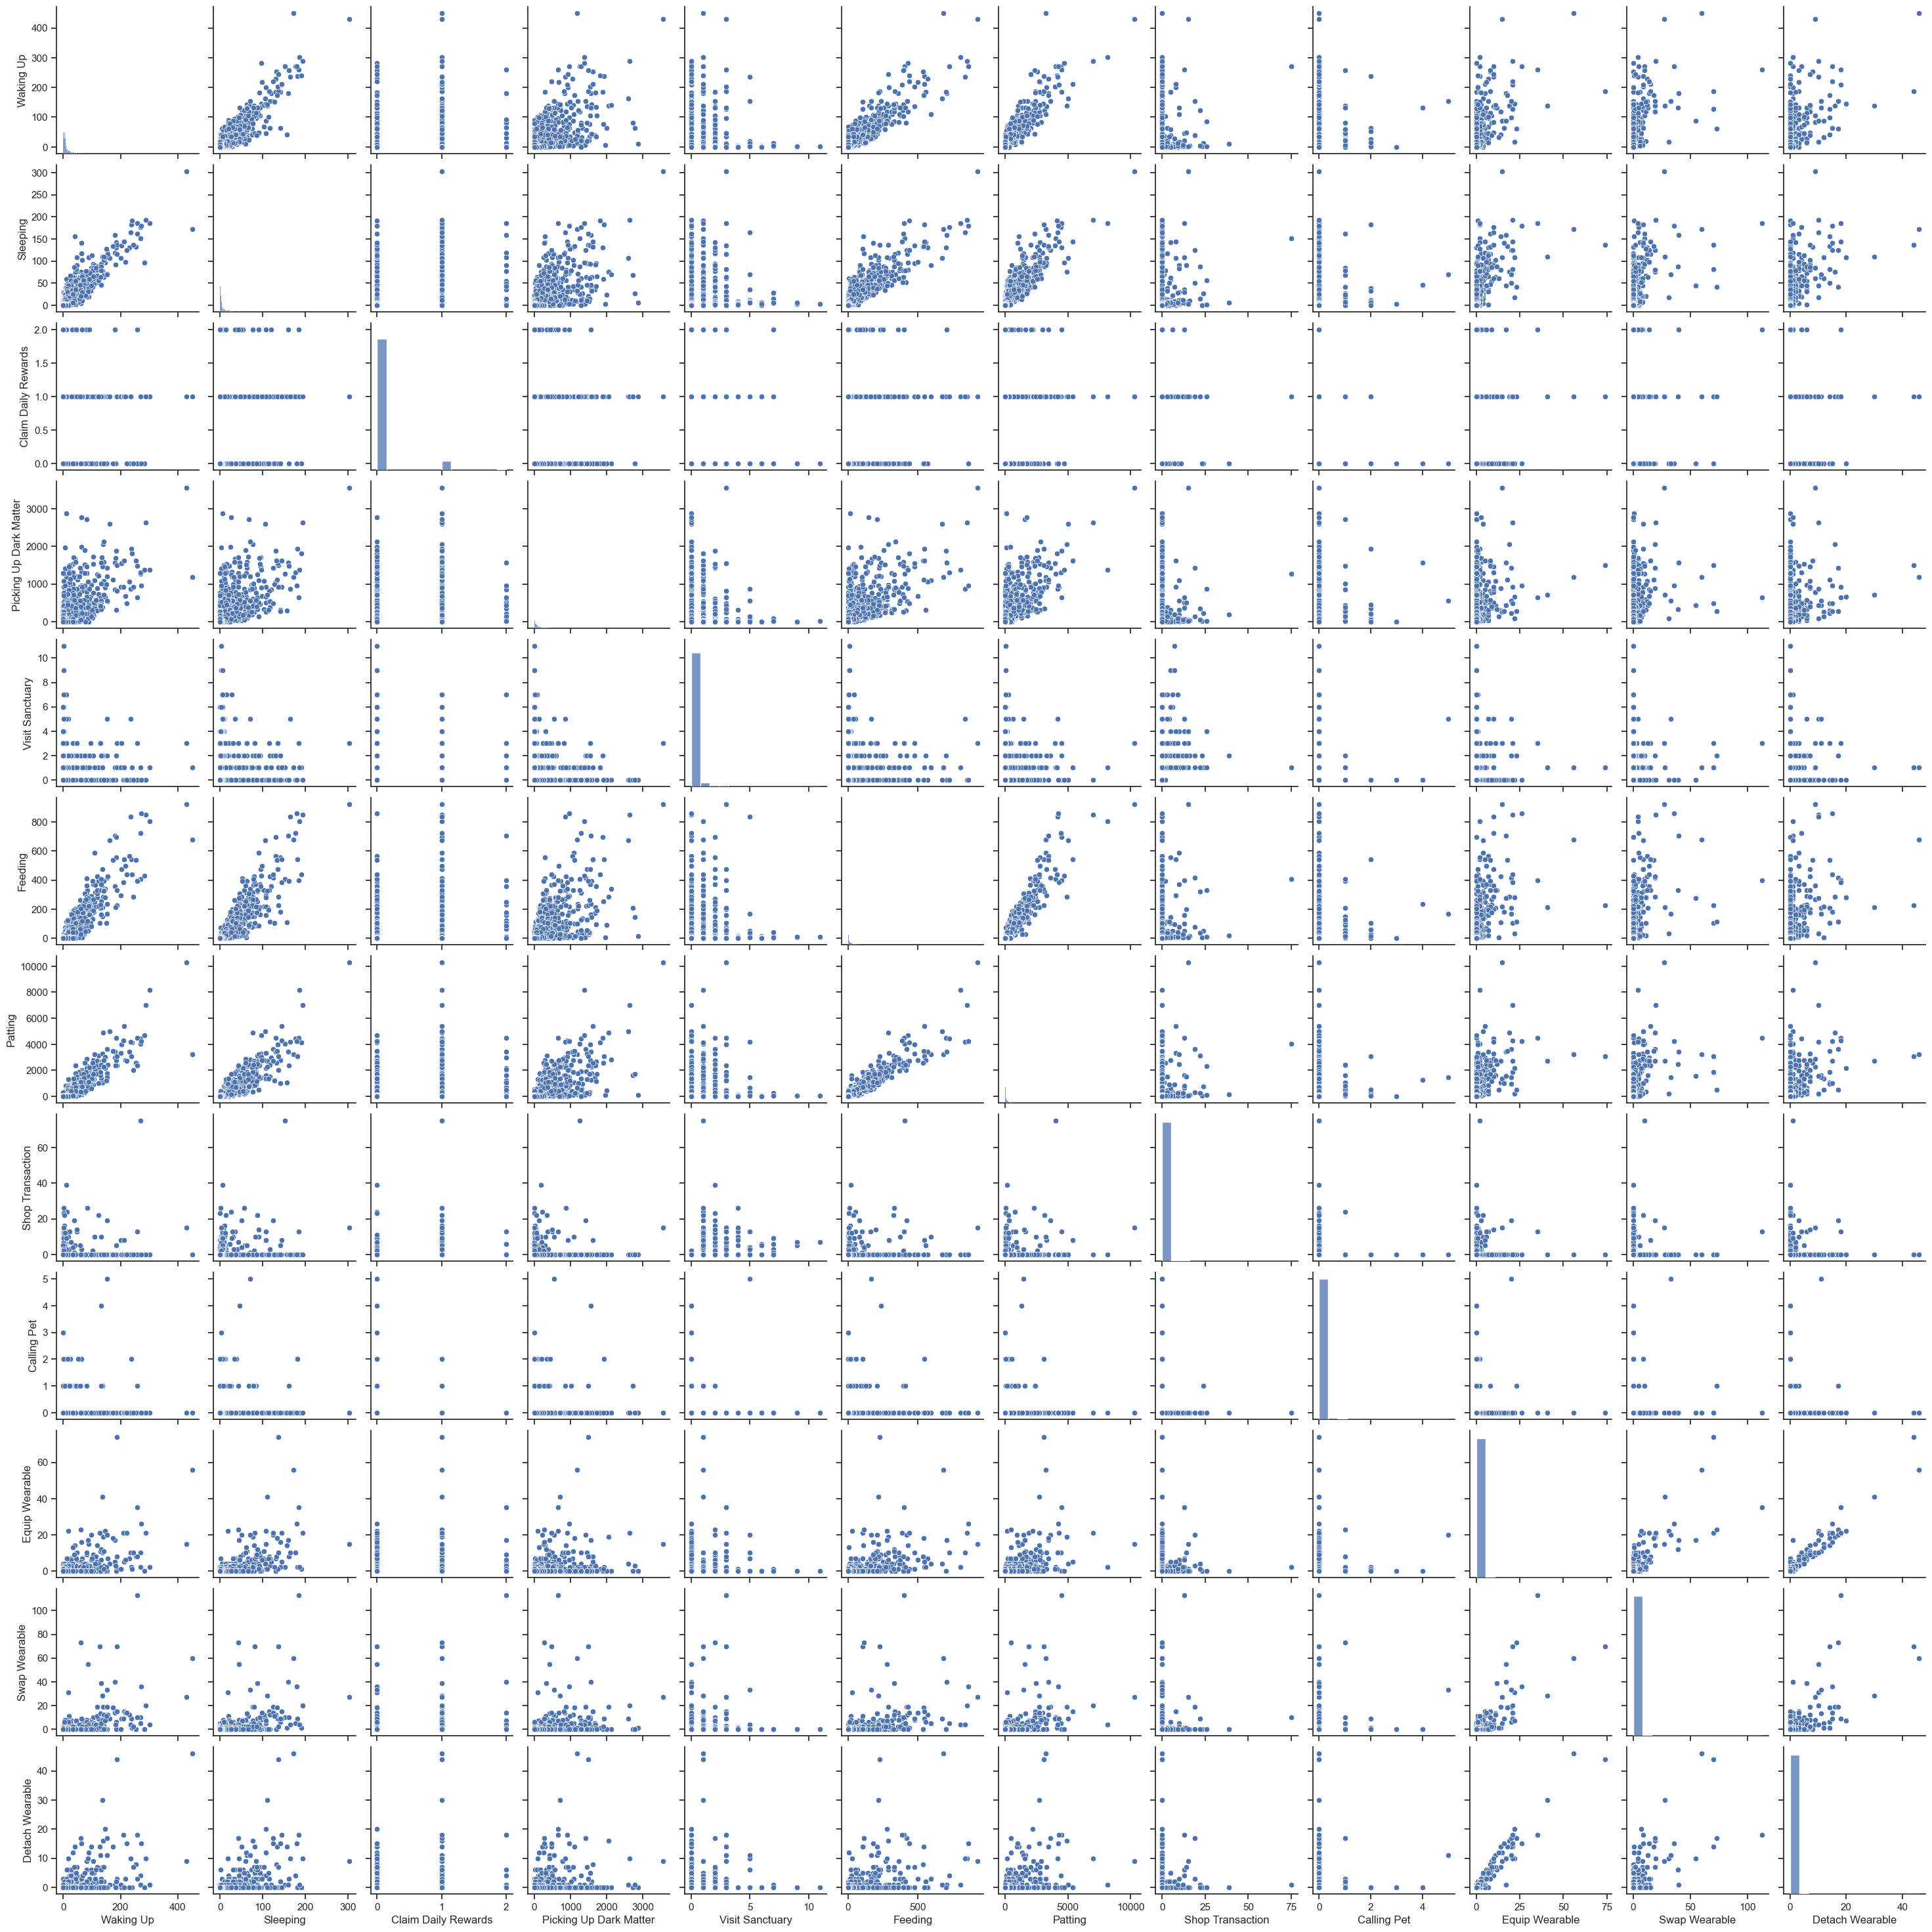

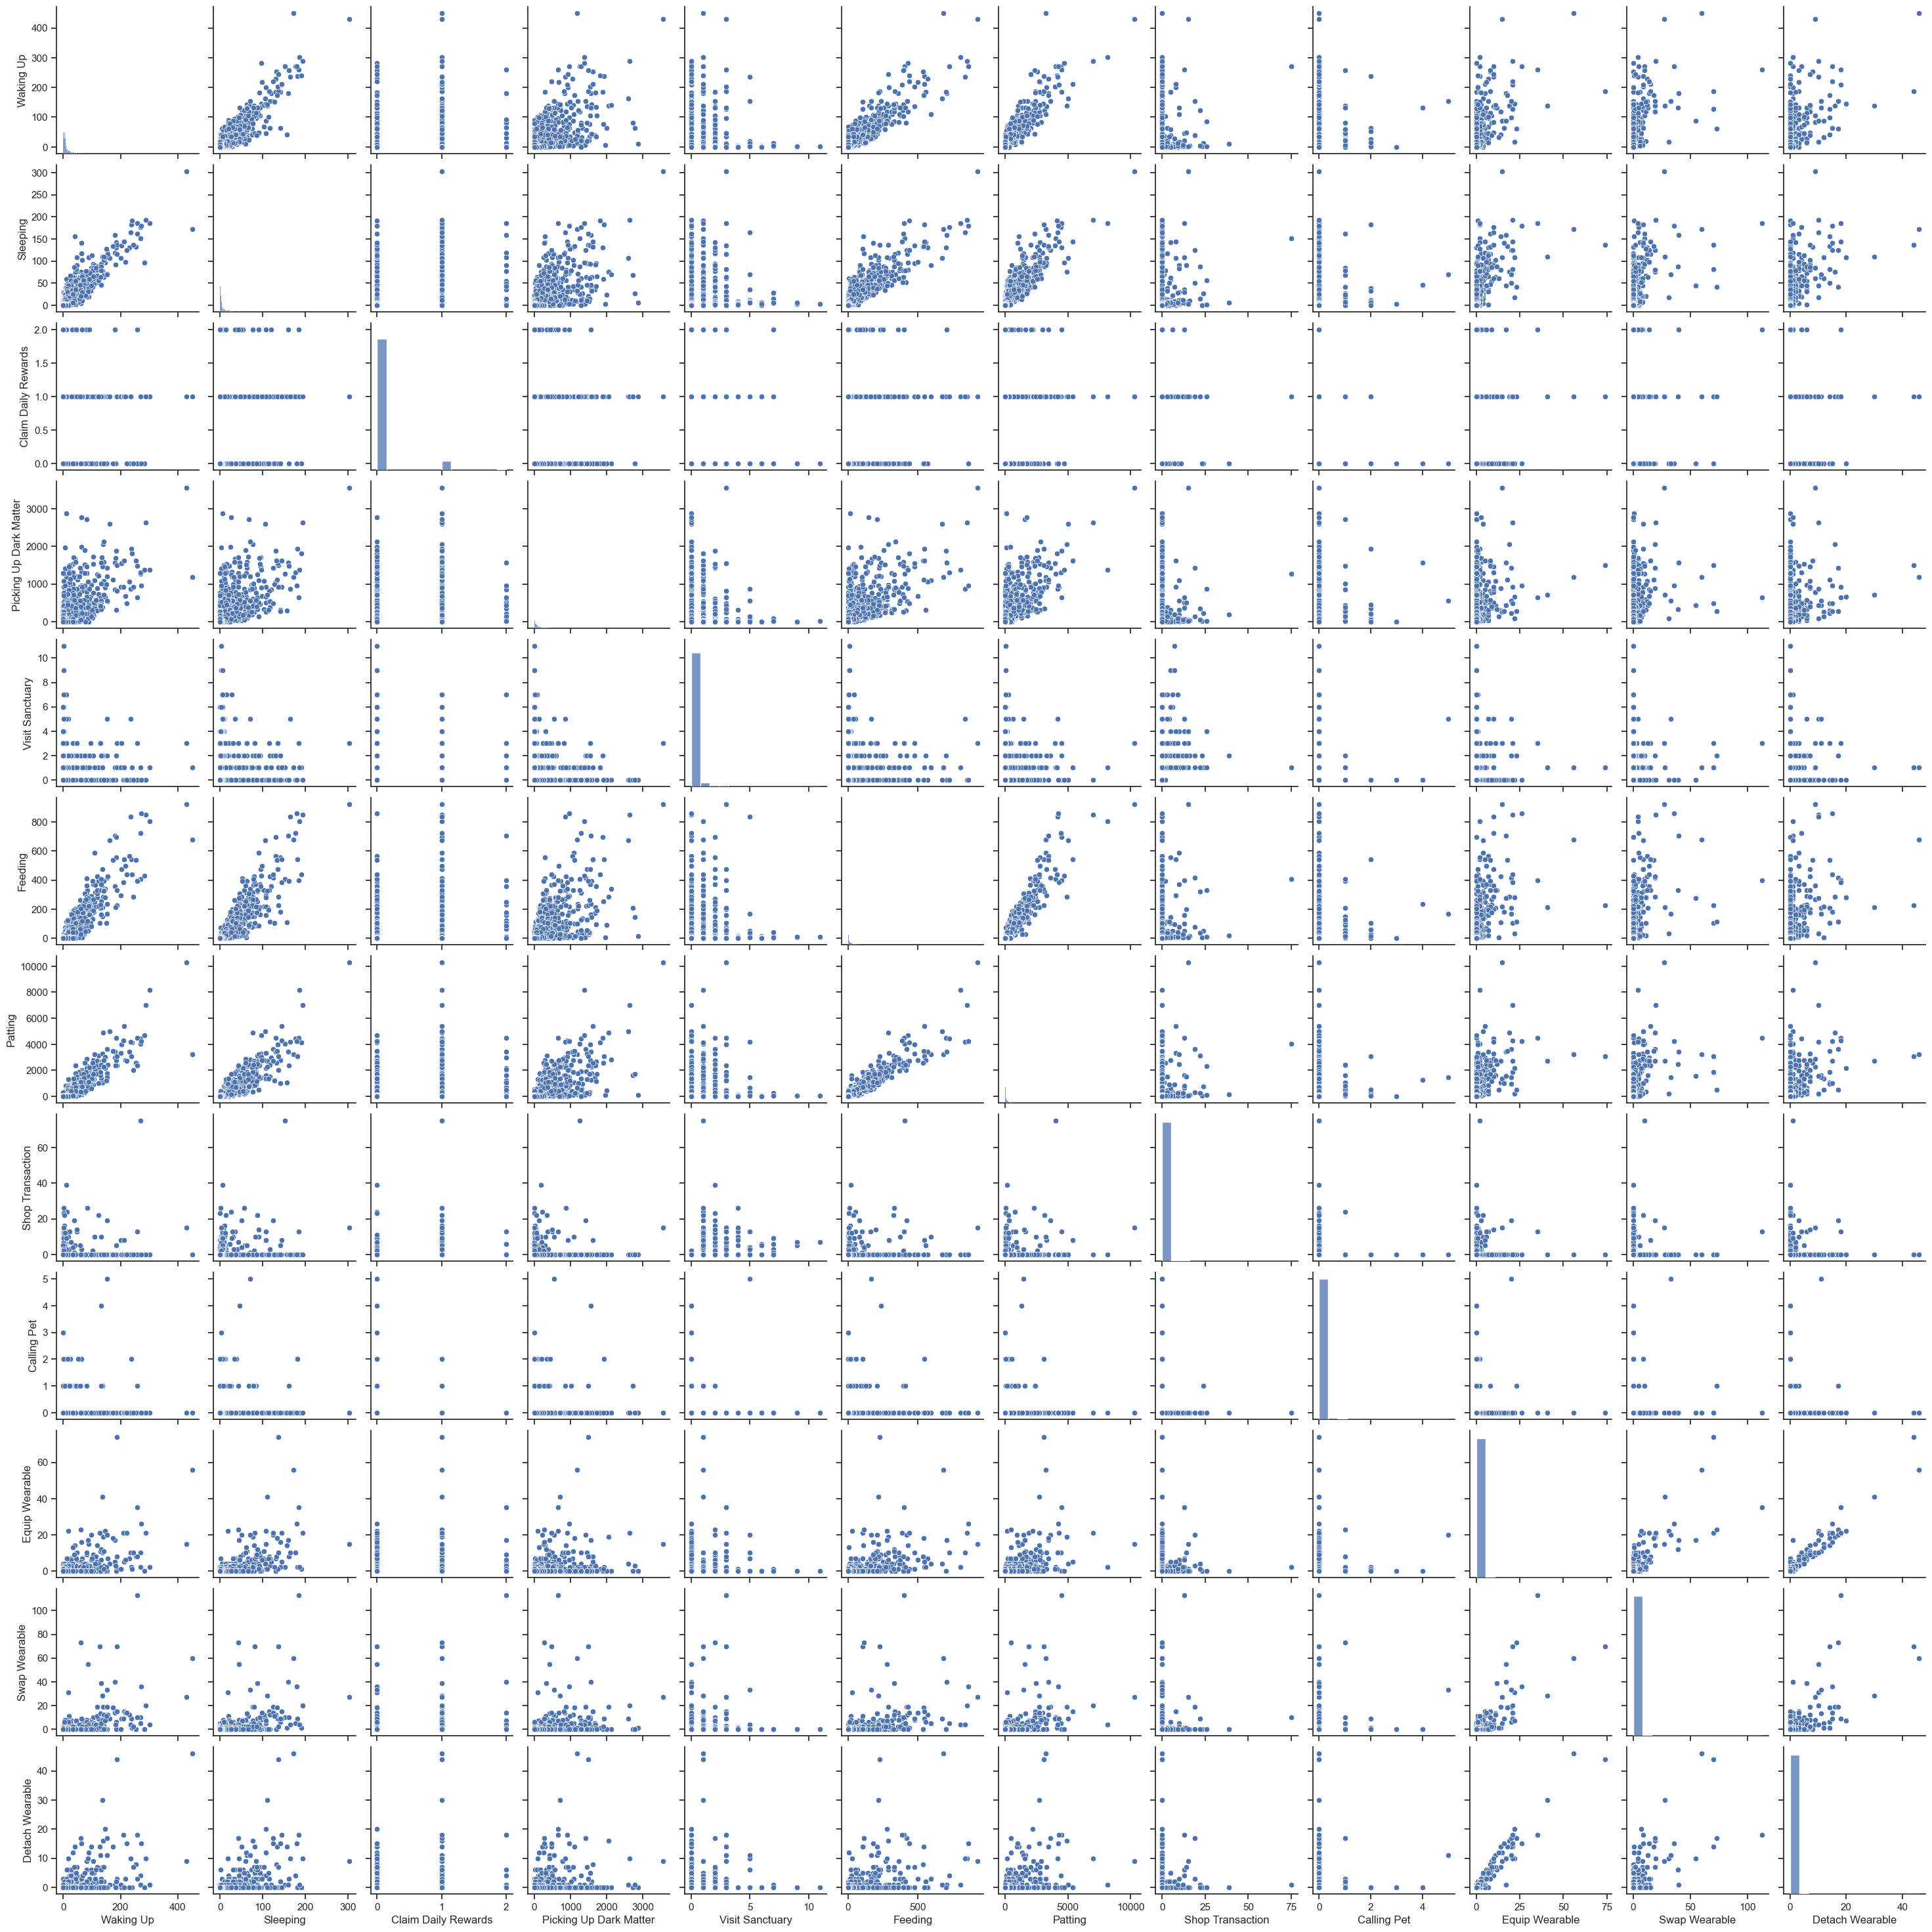

In [114]:
# Plot data
sns.set(style="ticks")
sns.pairplot(event_counts_pd)
plt.show()

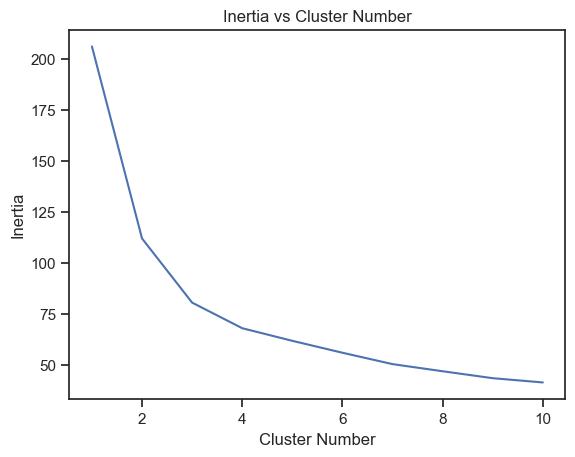

In [115]:
# Select all columns but distinct_id
X = event_counts_pd.iloc[:, 1:]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
for i in range(1, 11):
    kmeans = KMeans(
        n_clusters=i,
        init="k-means++",
        n_init=10,
        tol=1e-04,
        random_state=42
    )
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(np.arange(1, 11), inertia)
plt.title("Inertia vs Cluster Number")
plt.xlabel("Cluster Number")
plt.ylabel("Inertia")
plt.show()

In [119]:
# Perform clustering using K-means
kmeans = KMeans(
    n_clusters=3,
    init="k-means++",
    n_init=10,
    tol=1e-04, 
    random_state=42
)
kmeans.fit(X_scaled)

clusters = pd.DataFrame(X_scaled)
clusters['label'] = kmeans.labels_
polar = clusters.groupby("label").mean().reset_index()
polar = pd.melt(polar, id_vars=["label"])

# Name the cluster variables
event_names = event_counts.to_pandas().columns[1:].to_list()
polar["variable"] = polar["variable"].map(lambda x: event_names[x])
polar

,label,variable,value
0,0,Waking Up,0.026003
1,1,Waking Up,0.059000
2,2,Waking Up,0.370649
3,0,Sleeping,0.019440
4,1,Sleeping,0.081625
5,2,Sleeping,0.361793
6,0,Claim Daily Rewards,0.000000
7,1,Claim Daily Rewards,0.529740
8,2,Claim Daily Rewards,0.246753
9,0,Picking Up Dark Matter,0.019966


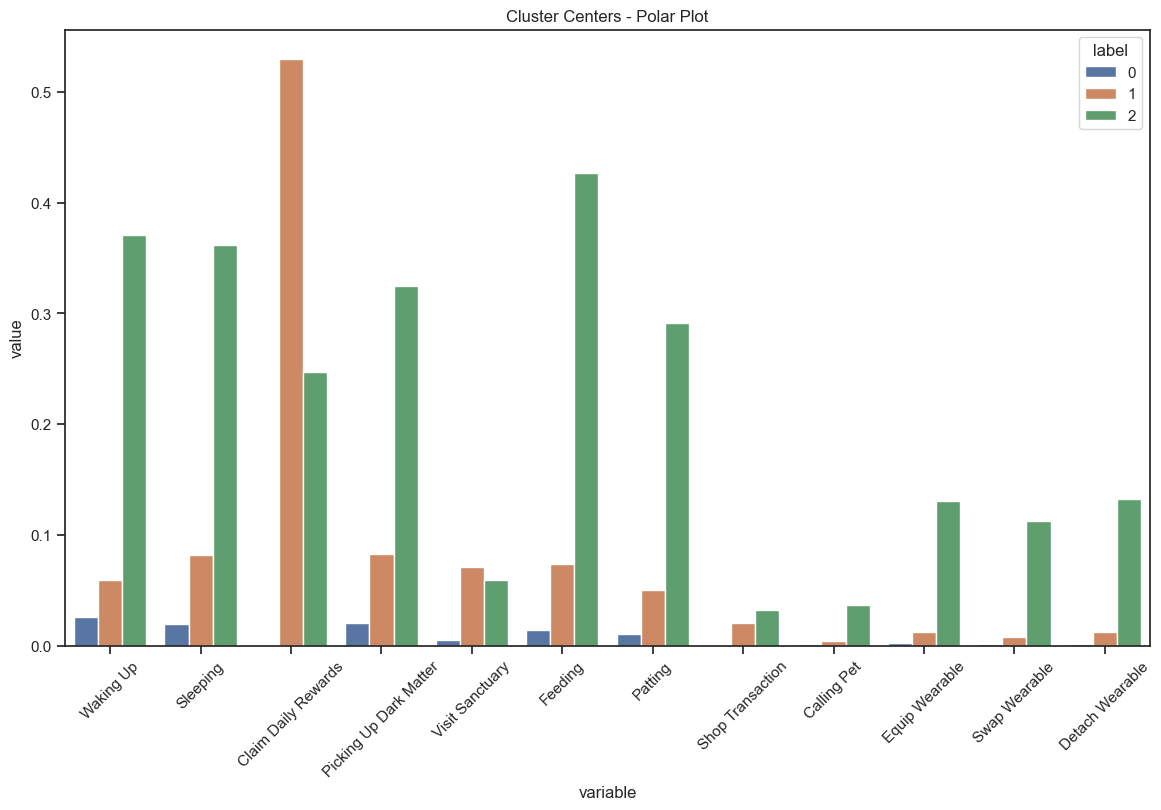

In [120]:
# Visualize the clusters
plt.figure(figsize=(14, 8))
sns.barplot(data=polar, x="variable", y="value", hue="label")
plt.xticks(rotation=45)
plt.title("Cluster Centers - Polar Plot")
plt.show()

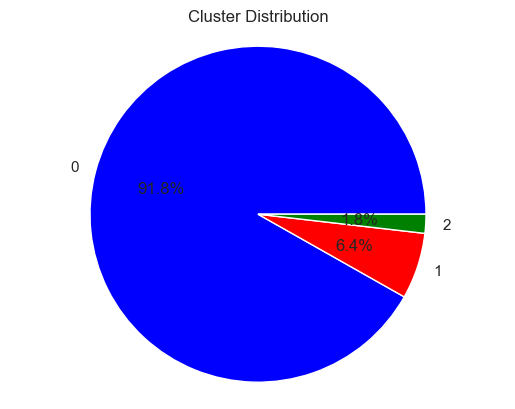

In [121]:
pie = clusters.groupby('label').size().reset_index()
pie.columns = ['label', 'value']

sns.set(style="whitegrid")
plt.pie(pie['value'], labels=pie['label'], colors=['blue', 'red', 'green'], autopct='%1.1f%%')
plt.axis('equal')
plt.title("Cluster Distribution")
plt.show()